In [1]:
import os
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import silhouette_samples
import seaborn as sns
import pickle

import sklearn.preprocessing as skp

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from sklearn.decomposition import KernelPCA, PCA

from sklearn.metrics import silhouette_samples
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering

from mpl_toolkits.mplot3d import Axes3D


from math import cos,sin,tan,asin,acos,radians,sqrt,degrees,atan,copysign,atan2
import math

import random
import datetime

import joblib
import subprocess


In [2]:
#Process to Clusters
#1. Transform Fit of Helical Parameters to MidpointDist/ Dihedral Angles
#2. Apply StandardScaler Dist_Dihe [Save to use on new data later]
#3. Save cluster labels and features for training of Spectral Neural Net
#4. Train Spectral Neural Net
#5. Save weights for Siamese and Spectral Net

#Process New Data with Spectral Net
#1. Transform from Helical Parameters to MidpointDist/ Dihedral Angles
#2. Load StandardScaler and apply to dist_dihe data
#3. Save scaled features for prediction by SpecNet
#4. Load SpecNet, fake train one epoch to intialize, Load weights
#5. Predict scaled dist_dihe data
#6. Save cluster predictions

In [3]:
class ClusterHelixParams():
    
    def __init__(self,name,direc='data/', load_scaler=None,loadCluster = False):
        """Spectral Clustering, Visualization and connection to Spectral Neural Net"""
        #new cluster creates new scaler,  loads scaler from reference
        #ie training data = new cluster, mL generated data no new clusters
        self.name = name
        self.direc=direc
        rr = np.load(f'{direc}{self.name}.npz', allow_pickle=True)
        
        
        if loadCluster:
            #Loading data for plotting
            self.y_, self.y_train, self.X_train, self.featNames = [rr[f] for f in rr.files]
            #self.y_, self.y_train, self.X_train = [rr[f] for f in rr.files]
            self.stdsc = joblib.load(f'{direc}{name}_scaler.gz')
            self.cluster_labels = np.unique(self.y_)
            self.n_clusters = self.cluster_labels.shape[0]
                 
        elif not load_scaler:
            #Loading data for clustering
            self.X_train, self.y_train, self.featNames = [rr[f] for f in rr.files]
            self.stdsc = skp.StandardScaler()
            self.X_train = self.stdsc.fit_transform(self.X_train)
        else:
            #loading data to include in clustering via spectral net
            self.X_train, self.y_train, self.featNames = [rr[f] for f in rr.files]
            self.stdsc = joblib.load(f'{direc}{load_scaler}_scaler.gz')
            self.X_train = self.stdsc.transform(self.X_train)
            
        self.featsD = self.X_train[:,:-8] #removed length or phi values
        
    
    def saveClusters(self,name,direc='data/'):
            
        np.savez_compressed(f'{direc}{name}.npz', y_ = self.y_ , y_train = self.y_train, 
                            X_train=self.X_train, featNames = self.featNames)
        joblib.dump(self.stdsc, f'{direc}{name}_scaler.gz')
        
    
    def save_for_spectralNet(self,direc='data/', name='to_predict'):
        
        np.savez_compressed(f'{direc}{name}.npz',data = self.featsD)
    
    def load_for_spectralNet(self,direc='data/',newClust='clusters_specNet',origClust='original_clusters'):
        
        rr = np.load(f'{direc}{newClust}.npz', allow_pickle=True)
        
        self.y_ = [rr[f] for f in rr.files][0]
        
        self.cluster_labels = np.unique(self.y_)
        self.n_clusters = self.cluster_labels.shape[0]
        
        rr = np.load(f'{direc}{origClust}.npz', allow_pickle=True)
        
        self.original_dataset_y_ = [rr[f] for f in rr.files][0]
        
        return self.y_
        
    
    def sc(self,n_clusters=28,random_state=0, affinity='nearest_neighbors', n_neighbors=10):
        """Use spectral clustering to cluster."""
        
        self.sc = SpectralClustering(assign_labels='discretize',affinity=affinity, n_neighbors=n_neighbors,n_clusters=n_clusters,random_state=random_state)
        self.y_ = self.sc.fit_predict(self.featsD)
        
        self.cluster_labels = np.unique(self.y_)
        self.n_clusters = self.cluster_labels.shape[0]
        
        return self.y_

    
    def pcaPlot(self,plotNeg=True):
        
        pca = PCA(n_components=2)
        xt_pca = pca.fit_transform(self.featsD)
        
        for i, c in enumerate(self.cluster_labels):
            if c==-1 and not plotNeg:
                continue
            color = cm.jet(float(i+1)/self.n_clusters)
            axobj = plt.scatter(xt_pca[self.y_==c,0], xt_pca[self.y_==c,1],color = color, alpha = 0.5)
            
        return axobj
            
    def pca3DPlot(self,plotNeg=False):
        
        # Run The PCA
        pca = PCA(n_components=3)
        xt_pca=pca.fit_transform(self.featsD)
        
        
        
        fig = plt.figure(figsize=(20,20))
        ax = fig.add_subplot(111, projection='3d')
        

        for i, c in enumerate(self.cluster_labels):
            if c==-1 and not plotNeg:
                continue
            color = cm.jet(float(i+1)/self.n_clusters)
            ax.scatter3D(xt_pca[self.y_==c,0], xt_pca[self.y_==c,1],xt_pca[self.y_==c,2] ,color = color, alpha = 0.5)                   
    
    
    def tSNE_plot(self, perplexity=30.0):
        """Make tSNE plot"""
        
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        tn = TSNE(perplexity=perplexity)
        
        sneReduced=tn.fit_transform(self.featsD)
        
        
        palette = sns.color_palette("hls", self.n_clusters)
        sns.scatterplot(x=sneReduced[:,0], y=sneReduced[:,1], hue=self.y_, palette=palette)
    
    def silPlot(self):
        """Make Silhouette Plot"""

        self.silhouette_vals = silhouette_samples(self.featsD, self.y_, metric='euclidean')
        
        y_ax_lower, y_ax_upper = 0,0
        yticks=[]
        
        for i, c in enumerate(self.cluster_labels):
            c_silhouette_vals = self.silhouette_vals[self.y_ == c]
            c_silhouette_vals.sort()
            y_ax_upper += len(c_silhouette_vals)
            color = cm.jet(float(i) / self.n_clusters)
            plt.barh(range(y_ax_lower, y_ax_upper),
                    c_silhouette_vals,
                    height = 1.0,
                    edgecolor = 'none',
                    color=color)
            yticks.append((y_ax_lower+y_ax_upper) / 2.)
            y_ax_lower += len(c_silhouette_vals)
        silhouette_avg = np.mean(self.silhouette_vals)
        plt.axvline(silhouette_avg, color='red', linestyle="--")
        plt.yticks(yticks, self.cluster_labels +1)
        plt.xlabel('Silhouette Coeffecient')
        
    def compare_Clusters(self):
        """Plots cluster distribution from ref data set and generated helices"""
        oClus = []
        nClus = []
        
        for x in range(self.n_clusters):
            oClus.append(len(np.where(self.original_dataset_y_==x)[0]))
            nClus.append(len(np.where(self.y_== x)[0]))
            
        nums =  list(range(self.n_clusters))
        nums.extend(nums)
        oldList = ['reference' for x in range(self.n_clusters)]
        newList = ['generated' for x in range(self.n_clusters)]
        oldList.extend(newList)
        oClus.extend(nClus)
            
        data1 = {'cluster':nums, 'amount': oClus, 'type': oldList}
        
        df = pd.DataFrame(data=data1)
        sns.barplot(x="cluster", y="amount", data=data1, hue='type')
        return df 
        
    def getRandomExamples(self,numRetrieve=1):
        """Check clustering by looking at random members of clusters"""
        cluster_examples = []
        
        for x in range(len(self.cluster_labels)):
            cluster = self.y_train[self.y_== self.cluster_labels[x]]
            cluster_examples.append(random.choice(cluster,k=numRetrieve))
             
        return cluster_examples
    
    def getSilSortedExamples(self,numRetrieve=1):
        """Check clustering by checking the most similar members of clusters"""
        self.silhouette_vals = silhouette_samples(self.featsD, self.y_, metric='euclidean')
        
        cluster_examples = []
        
        for i, c in enumerate(self.cluster_labels):
            c_silhouette_vals = self.silhouette_vals[self.y_ == c]
            c_names = self.y_train[self.y_ == c]
            index = c_silhouette_vals.argsort()
            
            self.clustered_poses.append([])
            c_silhouette_vals = c_silhouette_vals[index]
            cluster_examples.append(c_names[index])
            
        return cluster_examples
                

    
        

In [4]:
chp = ClusterHelixParams('refData',loadCluster=True)
#chp.silPlot()

In [5]:
chp.load_for_spectralNet()

array([10, 10,  1, ...,  4,  2, 18])

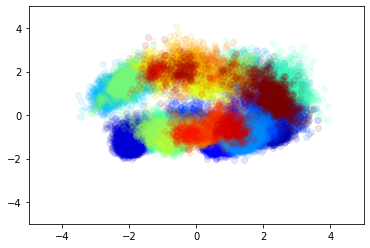

In [9]:
pca = PCA(n_components=2)
xt_pca = pca.fit_transform(chp.featsD)


plt.ylim(-5,5)
plt.xlim(-5,5)

for i, c in enumerate(chp.cluster_labels):
    if c==-1 and not plotNeg:
        continue
    color = cm.jet(float(i+1)/chp.n_clusters)
    axobj = plt.scatter(xt_pca[chp.original_dataset_y_==c,0], xt_pca[chp.original_dataset_y_==c,1],color = color, alpha = 0.1)

In [ ]:
pca = PCA(n_components=2)
xt_pca = pca.fit_transform(chp.featsD)


plt.ylim(-5,5)
plt.xlim(-5,5)

for i, c in enumerate(chp.cluster_labels):
    if c==-1 and not plotNeg:
        continue
    color = cm.jet(float(i+1)/chp.n_clusters)
    axobj = plt.scatter(xt_pca[chp.original_dataset_y_==c,0], xt_pca[chp.original_dataset_y_==c,1],color = color, alpha = 0.5)

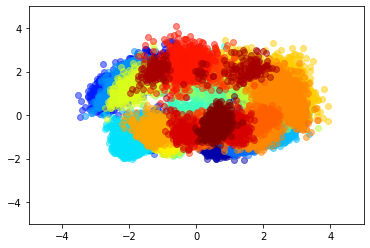

In [86]:
plt.ylim(-5,5)
plt.xlim(-5,5)
aa=chp.pcaPlot()

In [87]:
bb = aa.get_figure()

In [88]:
bb.savefig(f'../Figures/GAN_Figure/pca_ref.svg')

In [14]:
# chp.sc(n_clusters=26,random_state=0, affinity='nearest_neighbors', n_neighbors=10)
# chp.silPlot()

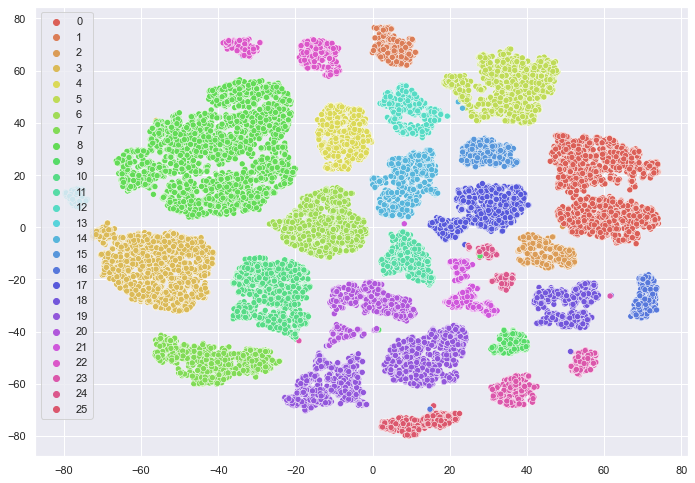

In [59]:
chp.tSNE_plot()

In [60]:
chp.saveClusters('refData') #saves clustering and scaler for training spectral net and scaling new data

In [10]:
chp_new = ClusterHelixParams('bestGen_dist_dihe2',load_scaler='refData') #scale the new data using the old scaler
# chp_new.save_for_spectralNet() # save for loading by spectral net, produces to_predict.npz

In [11]:
chp_new.load_for_spectralNet()

array([10, 10,  1, ...,  4,  2, 18])

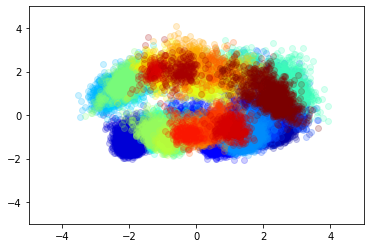

In [22]:
pca = PCA(n_components=2)
xt_pca = pca.fit_transform(chp.featsD)


plt.ylim(-5,5)
plt.xlim(-5,5)

for i, c in enumerate(chp.cluster_labels):
    if c==-1 and not plotNeg:
        continue
    color = cm.jet(float(i+1)/chp.n_clusters)
    axobj = plt.scatter(xt_pca[chp.original_dataset_y_==c,0], xt_pca[chp.original_dataset_y_==c,1],color = color, alpha = 0.2)
    
bb = axobj.get_figure()
bb.savefig(f'../Figures/GAN_Figure/pca_ref.svg')

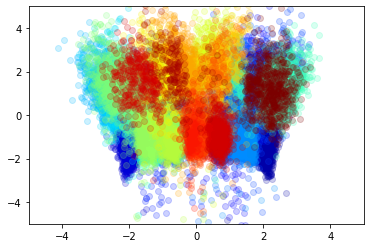

In [21]:
pca = PCA(n_components=2)
xt_pca = pca.fit_transform(chp_new.featsD)


plt.ylim(-5,5)
plt.xlim(-5,5)

for i, c in enumerate(chp_new.cluster_labels):
    if c==-1 and not plotNeg:
        continue
    color = cm.jet(float(i+1)/chp_new.n_clusters)
    axobj = plt.scatter(-xt_pca[chp_new.y_==c,0], -xt_pca[chp_new.y_==c,1],color = color, alpha = 0.2)
    
bb = axobj.get_figure()
bb.savefig(f'../Figures/GAN_Figure/pca_generated.svg')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 27000 but corresponding boolean dimension is 22000

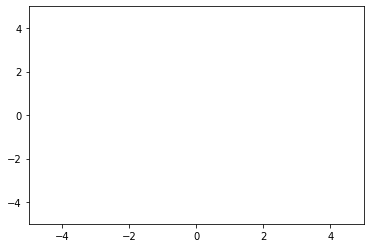

In [92]:
pca = PCA(n_components=2)
xt_pca = pca.fit_transform(chp_new.featsD)


plt.ylim(-5,5)
plt.xlim(-5,5)

for i, c in enumerate(chp_new.cluster_labels):
    if c==-1 and not plotNeg:
        continue
    color = cm.jet(float(i+1)/chp_new.n_clusters)
    axobj = plt.scatter(-xt_pca[chp_new.original_dataset_y_==c,0], -xt_pca[chp_new.original_dataset_y_==c,1],color = color, alpha = 0.5)

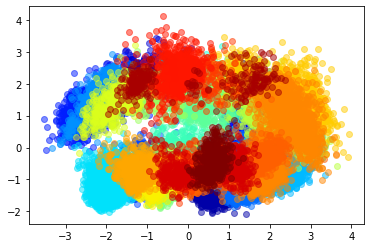

In [75]:
aa=chp.pcaPlot()

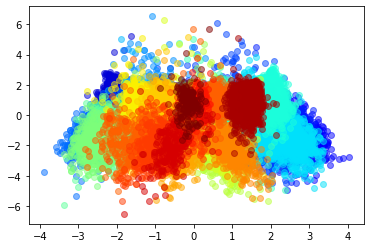

In [85]:
chp_new.pcaPlot()

In [53]:
snsplot1 = chp_new.compare_Clusters()

In [94]:
len(chp_new.original_dataset_y_)

22000

In [ ]:
#Figure Stuff

In [54]:
color =["#33ffa5","#33c4ff"]

sns.set_palette(color)

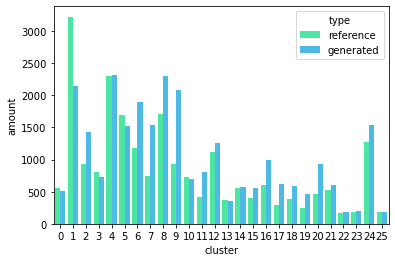

In [58]:

ax = sns.barplot(x="cluster", y="amount", data=snsplot1, hue='type')
fig = ax.get_figure()


In [59]:
fig.savefig(f'../Figures/GAN_Figure/clustercompare.svg')

In [19]:
snsplot1.savefig(f'../Figures/HelicalFit_Figure/clustercompare.svg')

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

In [17]:
together=[0,1,2,8,9,14,15,17,18,19,20,23]#check manually excludes 21 and 22 which are mixed
apart = [3,4,5,6,7,10,11,12,13,16,24,25] 

In [18]:
tsum = 0
asum = 0
for x in range(chp.n_clusters):
    tot = len(np.where(chp.y_ == x)[0])
    if x in together:
        tsum += tot
    if x in apart:
        asum += tot
    

In [19]:
tsum

15122

In [31]:
np.where(np.array([1])==np.array([1,2,3]))

(array([0], dtype=int64),)

In [85]:
#chp = ClusterHelixParams('dist_dihe_4H')
#chp.sc(n_clusters=28,random_state=0, affinity='nearest_neighbors', n_neighbors=10)
#chp.pcaPlot() #visualization of choice 
#chp.saveClusters('refData') #saves clustering and scaler for training spectral net and scaling new data

In [ ]:
#chp_new = ClusterHelixParams('dist_dihe_BestGenerator',load_scaler='refData') #scale the new data using the old scaler
#chp_new.save_for_spectralNet() # save for loading by spectral net, produces to_predict.npz

In [ ]:
#run Clustering_SpectralNeuralNet to read to_predict.npz and saves 'clusters_specNet.npz' and 'original_clusters.npz'

In [ ]:
#chp_new.load_for_spectralNet() #load and view graphs as desired